In [1]:
import itertools
import joblib
import pickle 

import networkx as nx
import numpy as np
import pandas as pd
import cvxpy as cp

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns
import random 
import joblib

import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params
import random
import numpy as np
import networkx as nx

from src.CBN import CausalBayesianNetwork as CBN
import modularised_utils as mut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import evaluation_utils as evut
import opt_utils as oput
import params

np.random.seed(0)

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
experiment = 'battery_discrete'

In [3]:
T_results_emp = joblib.load(f"data/{experiment}/diroca_train_results_empirical.pkl")

In [4]:
coeff_estimation = True

Dll_obs, Dhl_obs  = mut.load_samples(experiment)[None][0], mut.load_samples(experiment)[None][1] 

Gll, Ill = mut.load_model(experiment, 'LL')
Ghl, Ihl = mut.load_model(experiment, 'HL')

n_varsll, n_varshl = len(Gll.nodes()), len(Ghl.nodes())

omega    = mut.load_omega_map(experiment)

if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)

LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels = {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

In [ ]:
data = 

In [6]:
test_observ        = True
test_interv        = True 
metric             = 'fro'
num_iter           = 20

if test_observ and test_interv:
    test_data = data

elif test_observ:
    test_data = {None: data[None]}

elif test_interv:
    test_data = {k: v for k, v in data.items() if k is not None}

Test theorem

In [9]:
def mod_noise(U_samples, intervention):
    """
    Modify exogenous noise for exact interventions by setting the entire column 
    to the intervention value for each intervened variable.
    
    Args:
        U_samples: Original noise samples (n_samples x n_variables)
        intervention: Intervention object or None
    """
    U_modified = U_samples.copy()
    
    if intervention is not None:
        # Get dictionary of interventions
        intervention_dict = intervention.vv()
        
        # For each intervened variable
        for var in intervention.Phi():  # Use Phi() to get variables
            value = intervention_dict[var]
            
            # If var is already an integer index, use it directly
            if isinstance(var, (int, np.integer)):
                var_idx = var
            # Otherwise try to get the name or string representation
            else:
                var_idx = str(var)
                # Map variable name to index based on your convention
                # For example, if 'CG' maps to 0, 'ML1' to 1, etc.
                var_map = {'CG': 0, 'ML1': 1, 'ML2': 2, 'S': 0, 'T': 1}
                var_idx = var_map.get(var_idx, 0)  # default to 0 if not found
            
            # Set entire column to intervention value
            U_modified[:, var_idx] = value
    
    return U_modified

In [10]:
results_single = {method: {'errors': [], 'mean': 0, 'ci': 0} for method in T_results_emp.keys()}

for name, method_data in T_results_emp.items():
    T = method_data['T_matrix']
    errors = []  # Store errors for each intervention
    scale_factor = 1/np.sqrt(len(Ill))

    for iota in Ill:
        L_i = LLmodels[iota].F
        H_i = HLmodels[omega[iota]].F
        if iota is not None:
            D_l = L_i @ mod_noise(U_ll_hat, iota).T
            D_h = H_i @ mod_noise(U_hl_hat, omega[iota]).T
        else:
            D_l = L_i @ U_ll_hat.T
            D_h = H_i @ U_hl_hat.T
        
        base_norm = D_l #/ np.linalg.norm(D_l, 'fro')
        abst_norm = D_h #/ np.linalg.norm(D_h, 'fro')
        
        tau_base = T @ base_norm
        dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
        errors.append(dist)  # Store individual errors
   
    # Calculate mean and CI
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    ci = 1.96 * std_error

    # Store all statistics
    results_single[name] = {
        'errors': errors,
        'mean': mean_error,
        'ci': ci
    }

# Scale the final results
max_mean = max(v['mean'] for v in results_single.values())
scale_factor = 1/max_mean

# # Scale means and CIs
# for method in results_single:
#     results_single[method]['mean'] *= scale_factor
#     results_single[method]['ci'] *= scale_factor

# Sort by mean error
results_single = dict(sorted(results_single.items(), key=lambda x: x[1]['mean']))

# Print results
print("\n" + "="*100)
print(f"{'Method':<15} {'Error (mean ± CI)':<35}")
print("="*100)

for method, stats in results_single.items():
    print(f"{method:<15} {stats['mean']:>8.4f} ± {stats['ci']:<8.4f}")


Method          Error (mean ± CI)                  
T_s               5.9888 ± 3.4333  
T_2               7.4622 ± 3.9388  
T_1               7.6669 ± 3.9398  
T_8               9.4874 ± 4.3440  
T_4               9.4874 ± 4.3440  
T_0.346-0.393     9.6628 ± 5.2721  
T_0.00           16.7029 ± 12.5332 
T_b              17.9670 ± 13.6943 
T_na             43.4111 ± 44.6536 
T_pa             51.5993 ± 55.2557 


In [11]:
rad_values = np.arange(0.05, 10.05, 1).tolist()  
#rad_values = [0.05, 1, 2,3, 4, 5, 10, 50]
sample_forms = ['boundary', 'sample']

In [12]:
hat_dict = {'L': U_ll_hat, 'H': U_hl_hat}

In [13]:
worst = 'T_8'

In [14]:
U_worst_L = T_results_emp[worst]['optimization_params']['L']['pert_U']
U_worst_H = T_results_emp[worst]['optimization_params']['H']['pert_U']


In [15]:
worst_dict = {'L': U_worst_L, 'H': U_worst_H}

In [16]:
center = 'hat'
if center == 'hat':
    center_matrix = hat_dict
elif center == 'worst':
    center_matrix = worst_dict

In [17]:
coverage_type='uniform'

In [22]:
# Initialize results structure
results = {rad: {
    sample_form: {
        'empirical': {method: [] for method in T_results_emp.keys()}
    } for sample_form in sample_forms
} for rad in rad_values}

for rad in tqdm(rad_values):
    for sample_form in sample_forms:
        for iter_num in range(3):
            pert_L = evut.generate_perturbation_matrix(rad, sample_form, 'L', hat_dict, coverage = coverage_type)
            pert_H = evut.generate_perturbation_matrix(rad, sample_form, 'H', hat_dict, coverage = coverage_type)
            
            for name, method_data in T_results_emp.items():
                T = method_data['T_matrix']
                    
                # total = 0
                # for iota in test_data.keys():

                #     base, abst = test_data[iota]
                    
                #     # Apply perturbations
                #     base_pert = base + pert_L
                #     abst_pert = abst + pert_H
                    
                #     # Normalize
                #     base_norm = base_pert #/ np.linalg.norm(base_pert, 'fro')
                #     abst_norm = abst_pert #/ np.linalg.norm(abst_pert, 'fro')
                    
                #     # Apply method and compute distance
                #     tau_base = base_norm @ T.T
                #     dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                #     total += dist
                total = 0
                for iota in Ill:
                    L_i = LLmodels[iota].F
                    H_i = HLmodels[omega[iota]].F
                   
                    D_l = L_i @ (center_matrix['L'].T + pert_L.T)
                    D_h = H_i @ (center_matrix['H'].T + pert_H.T)
                    
                    # Normalize
                    base_norm = D_l #/ np.linalg.norm(D_l, 'fro')
                    abst_norm = D_h #/ np.linalg.norm(D_h, 'fro')
                    
                    tau_base = T @ base_norm
                    dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                    total += dist
                
                # Store average error for this iteration
                iter_avg = total / len(Ill)
                results[rad][sample_form]['empirical'][name].append(iter_avg)


# Print results
print("\n" + "="*100)
print(f"{'Radius':<8} {'Sample Form':<12} {'Method':<15} {'Error (mean ± CI)':<35}")
print("="*100)

for rad in rad_values:
    for sample_form in sample_forms:
        print(f"\nRadius: {rad}, Sample form: {sample_form}")
        print("-"*100)
        
        # Create dictionary of method statistics
        method_stats = {}
        for method in T_results_emp.keys():
            errors = results[rad][sample_form]['empirical'][method]
            error_mean = np.mean(errors)
            error_std = np.std(errors)
            ci = 1.96 * error_std
            method_stats[method] = (error_mean, ci)
        
        # Sort methods by mean error (descending order for worst to best)
        sorted_methods = sorted(method_stats.items(), key=lambda x: x[1][0], reverse=True)
        
        # Print sorted results
        for method, (error_mean, ci) in sorted_methods:
            print(f"{rad:<8} {sample_form:<12} {method:<15} "
                  f"{error_mean:>8.4f} ± {ci:<8.4f}")

# Find best methods (already sorted, just take last one)
for rad in rad_values:
    for sample_form in sample_forms:
        print(f"\nRanking for radius {rad}, {sample_form} sampling (worst to best):")
        
        error_means = {method: np.mean(results[rad][sample_form]['empirical'][method])
                      for method in T_results_emp.keys()}
        
        # Sort by error value (descending)
        sorted_methods = sorted(error_means.items(), key=lambda x: x[1], reverse=True)
        
        # Print all methods with ranking
        for rank, (method, error) in enumerate(sorted_methods, 1):
            print(f"{rank}. {method:<15} (error: {error:.4f})")
    

100%|██████████| 10/10 [00:00<00:00, 116.22it/s]


Radius   Sample Form  Method          Error (mean ± CI)                  

Radius: 0.05, Sample form: boundary
----------------------------------------------------------------------------------------------------
0.05     boundary     T_pa             50.2513 ± 0.0313  
0.05     boundary     T_na             41.9109 ± 0.0180  
0.05     boundary     T_b              18.7721 ± 0.0809  
0.05     boundary     T_0.00           17.5331 ± 0.0828  
0.05     boundary     T_0.346-0.393    10.0519 ± 0.0964  
0.05     boundary     T_8               9.6490 ± 0.0892  
0.05     boundary     T_4               9.6490 ± 0.0892  
0.05     boundary     T_s               9.3729 ± 0.1010  
0.05     boundary     T_1               7.5038 ± 0.1101  
0.05     boundary     T_2               7.4637 ± 0.1096  

Radius: 0.05, Sample form: sample
----------------------------------------------------------------------------------------------------
0.05     sample       T_pa             50.1730 ± 0.2422  
0.05     samp

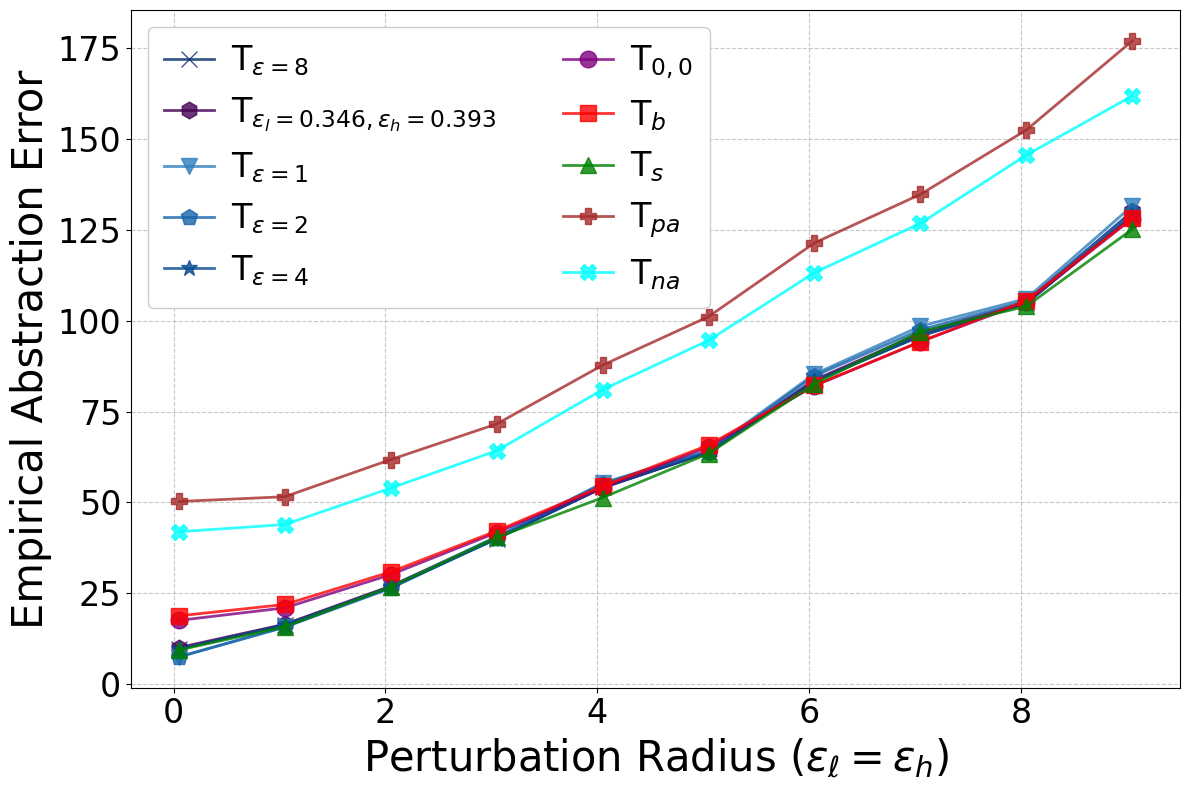

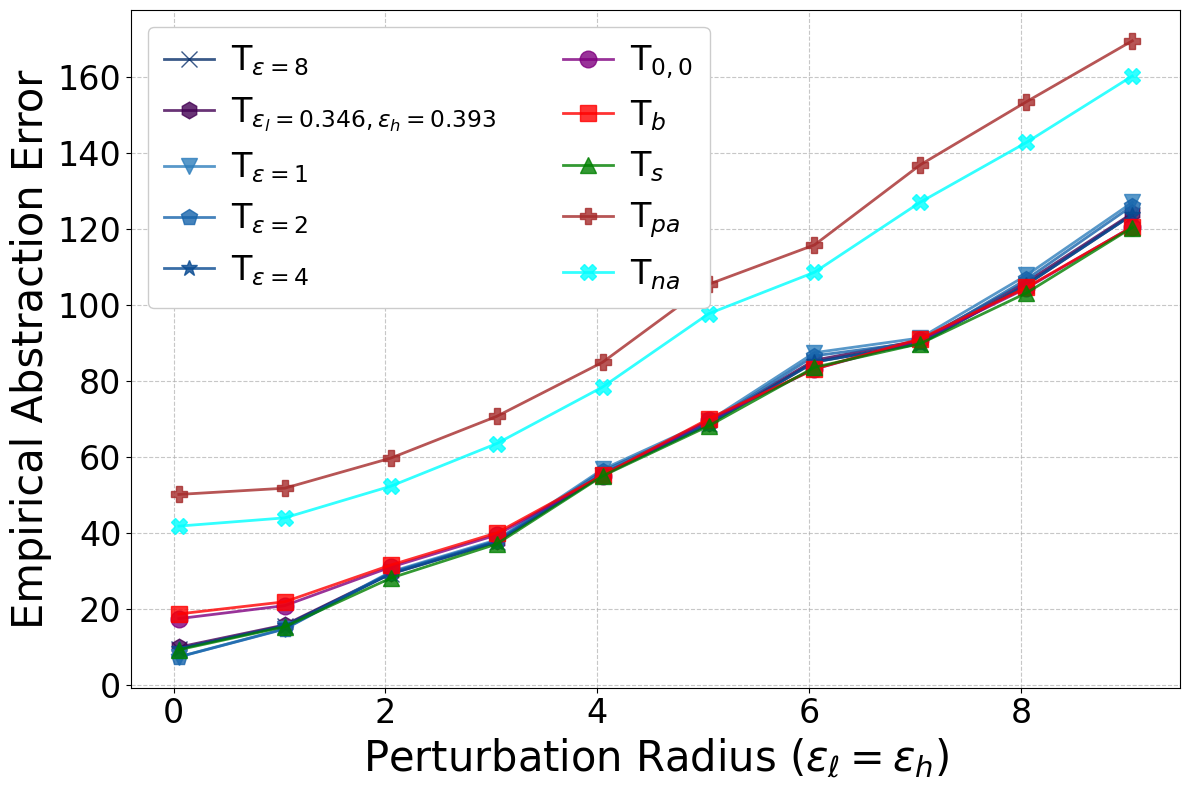

In [23]:
# Example usage with epsilon-delta methods
methods_to_plot = list(T_results_emp.keys())
evut.plot_empirical_abstraction_error(results, methods_to_plot, 'boundary')
evut.plot_empirical_abstraction_error(results, methods_to_plot, 'sample')

In [18]:
coverage_type = 'uniform'
center = 'hat'
if center == 'hat':
    center_matrix = hat_dict
elif center == 'worst':
    center_matrix = worst_dict

In [19]:
# Generate perturbation families
pert_family_L = evut.generate_perturbation_family(
    np.zeros_like(hat_dict['L']),
    k=10,  # Number of perturbations
    r_mu=0.0,
    r_sigma=1.0,
    coverage=coverage_type
)

pert_family_H = evut.generate_perturbation_family(
    np.zeros_like(hat_dict['H']),
    k=10,
    r_mu=0.0,
    r_sigma=1.0,
    coverage=coverage_type
)

In [20]:
# Initialize results structure to store individual distances
results = {
    sample_form: {
        'empirical': {method: [] for method in T_results_emp.keys()}
    } for sample_form in sample_forms
}

for pert_L, pert_H in zip(pert_family_L, pert_family_H):
    for sample_form in sample_forms:
        for name, method_data in T_results_emp.items():
            T = method_data['T_matrix']
            
            # Store individual distances for this perturbation
            distances = []
            
            for iota in Ill:
                L_i = LLmodels[iota].F
                H_i = HLmodels[omega[iota]].F
                
                if iota is not None:
                    D_l = L_i @ mod_noise(center_matrix['L'].T + pert_L.T, iota)
                    D_h = H_i @ mod_noise(center_matrix['H'].T + pert_H.T, omega[iota])
                else:
                    D_l = L_i @ (center_matrix['L'].T + pert_L.T)
                    D_h = H_i @ (center_matrix['H'].T + pert_H.T)
                
                # Normalize
                base_norm = D_l #/ np.linalg.norm(D_l, 'fro')
                abst_norm = D_h #/ np.linalg.norm(D_h, 'fro')
                
                tau_base = T @ base_norm
                dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                distances.append(dist)
            
            # Store all distances for this method and perturbation
            results[sample_form]['empirical'][name].extend(distances)

In [21]:
# Print results with ranking
print("\n" + "="*100)
print(f"{'Rank':<5} {'Method':<15} {'Empirical Distance (mean ± CI)':<35}")
print("="*100)

for sample_form in sample_forms:
    print(f"\nSample form: {sample_form}")
    print("-"*100)
    
    # Calculate means and stds for all methods
    method_stats = {}
    for method in T_results_emp.keys():
        distances = results[sample_form]['empirical'][method]
        mean = np.mean(distances)
        std = np.std(distances)
        method_stats[method] = (mean, std)
    
    # Sort methods by mean error (worst to best)
    sorted_methods = sorted(method_stats.items(), key=lambda x: x[1][0], reverse=True)
    
    # Print ranked results
    for rank, (method, (mean, std)) in enumerate(sorted_methods, 1):
        print(f"{rank:<5} {method:<15} "
              f"{mean:>8.4f} ± {1.96*std:<8.4f}")

print("="*100)

# Print summary of best and worst methods
for sample_form in sample_forms:
    print(f"\nSummary for {sample_form} sampling:")
    print("-"*100)
    
    # Get sorted methods
    method_stats = {method: (np.mean(results[sample_form]['empirical'][method]),
                           np.std(results[sample_form]['empirical'][method]))
                   for method in T_results_emp.keys()}
    sorted_methods = sorted(method_stats.items(), key=lambda x: x[1][0], reverse=True)
    
    # Print worst and best
    worst_method, (worst_error, worst_std) = sorted_methods[0]
    best_method, (best_error, best_std) = sorted_methods[-1]
    
    print(f"Worst method: {worst_method} (error: {worst_error:.4f} ± {1.96*worst_std:.4f})")
    print(f"Best method: {best_method} (error: {best_error:.4f} ± {1.96*best_std:.4f})")
    print(f"Error difference: {worst_error - best_error:.4f}")


Rank  Method          Empirical Distance (mean ± CI)     

Sample form: boundary
----------------------------------------------------------------------------------------------------
1     T_pa             50.3827 ± 1.2981  
2     T_na             42.0335 ± 1.1063  
3     T_b              18.8118 ± 0.3907  
4     T_0.00           17.5688 ± 0.3624  
5     T_0.346-0.393    10.1213 ± 0.2659  
6     T_8               9.7427 ± 0.2592  
7     T_4               9.7427 ± 0.2592  
8     T_s               9.4347 ± 0.2896  
9     T_1               7.7087 ± 0.3514  
10    T_2               7.6677 ± 0.3540  

Sample form: sample
----------------------------------------------------------------------------------------------------
1     T_pa             50.3827 ± 1.2981  
2     T_na             42.0335 ± 1.1063  
3     T_b              18.8118 ± 0.3907  
4     T_0.00           17.5688 ± 0.3624  
5     T_0.346-0.393    10.1213 ± 0.2659  
6     T_8               9.7427 ± 0.2592  
7     T_4              

In [28]:
# Initialize results structure
results_random = {method: [] for method in T_results_emp.keys()}

#for pert_L, pert_H in tqdm(zip(pert_family_L, pert_family_H)):
for i in tqdm(range(100)):
    rad = random.uniform(0.05, 10.05)
    sample_form = random.choice(['boundary', 'sample'])
    pert_L = evut.generate_perturbation_matrix(rad, sample_form, 'L', hat_dict, coverage = coverage_type).T
    pert_H = evut.generate_perturbation_matrix(rad, sample_form, 'H', hat_dict, coverage = coverage_type).T
    for name, method_data in T_results_emp.items():
        T = method_data['T_matrix']
            
        total = 0
        for iota in Ill:
            # base_norm, abst_norm = test_data[iota]
            # num_llsamples = base_norm.shape[0]
            # num_hlsamples = abst_norm.shape[0]
            # min_samples = min(num_llsamples, num_hlsamples)

            # base_norm = base_norm[:min_samples]
            # abst_norm = abst_norm[:min_samples]
            
            # tau_base = T @ base_norm.T
            # dist = np.linalg.norm(tau_base - abst_norm.T, ord='fro')
            L_i = LLmodels[iota].F
            H_i = HLmodels[omega[iota]].F
            
            D_l = L_i @ (center_matrix['L'].T + pert_L)
            D_h = H_i @ (center_matrix['H'].T + pert_H)
            
            # Normalize
            base_norm = D_l #/ np.linalg.norm(D_l, 'fro')
            abst_norm = D_h #/ np.linalg.norm(D_h, 'fro')
            
            tau_base = T @ base_norm
            dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
            total += dist
        
        # Store average error for this iteration
        iter_avg = total / len(test_data.keys())  # Changed from len(Ill) to len(test_data.keys())
        results_random[name].append(iter_avg)

100%|██████████| 100/100 [00:00<00:00, 919.85it/s]


In [29]:
# Print results with ranking
print("\n" + "="*100)
print(f"{'Rank':<5} {'Method':<15} {'Empirical Distance (mean ± CI)':<35}")
print("="*100)

for sample_form in sample_forms:
    print(f"\nSample form: {sample_form}")
    print("-"*100)
    
    # Calculate means for all methods
    method_means = {method: np.mean(results_random[method]) 
                   for method in T_results_emp.keys()}
    
    # Sort methods by mean error (worst to best)
    sorted_methods = sorted(method_means.items(), key=lambda x: x[1], reverse=True)
    
    # Print ranked results
    for rank, (method, mean) in enumerate(sorted_methods, 1):
        std = np.std(results_random[method])
        print(f"{rank:<5} {method:<15} "
              f"{mean:>8.4f} ± {1.96*std:<8.4f}")

print("="*100)

# Print summary of best and worst methods
for sample_form in sample_forms:
    print(f"\nSummary for {sample_form} sampling:")
    print("-"*100)
    
    # Get sorted methods
    method_means = {method: np.mean(results_random[method]) 
                   for method in T_results_emp.keys()}
    sorted_methods = sorted(method_means.items(), key=lambda x: x[1], reverse=True)
    
    # Print worst and best
    worst_method, worst_error = sorted_methods[0]
    best_method, best_error = sorted_methods[-1]
    
    print(f"Worst method: {worst_method} (error: {worst_error:.4f})")
    print(f"Best method: {best_method} (error: {best_error:.4f})")
    print(f"Error difference: {worst_error - best_error:.4f}")


Rank  Method          Empirical Distance (mean ± CI)     

Sample form: boundary
----------------------------------------------------------------------------------------------------
1     T_pa            112.4861 ± 88.5185 
2     T_na            103.2551 ± 85.1026 
3     T_b              71.8983 ± 68.7944 
4     T_0.00           71.4027 ± 69.2045 
5     T_s              71.0194 ± 72.6471 
6     T_4              70.9531 ± 62.3385 
7     T_1              70.6383 ± 74.7121 
8     T_8              70.5303 ± 61.2060 
9     T_0.346-0.393    70.1512 ± 72.7545 
10    T_2              66.4230 ± 69.4762 

Sample form: sample
----------------------------------------------------------------------------------------------------
1     T_pa            112.4861 ± 88.5185 
2     T_na            103.2551 ± 85.1026 
3     T_b              71.8983 ± 68.7944 
4     T_0.00           71.4027 ± 69.2045 
5     T_s              71.0194 ± 72.6471 
6     T_4              70.9531 ± 62.3385 
7     T_1              

# F-contamination

In [24]:
def contaminate_empirical_data(data, contamination_fraction, contamination_type, num_segments=10, seed=None):
    """
    Contaminates empirical data to introduce nonlinearities or piecewise changes.
    
    Args:
        data (np.ndarray): Original data matrix (n_samples x n_features)
        contamination_fraction (float): Magnitude of contamination (e.g., between 0.05 and 1.0)
        contamination_type (str): Type of contamination to apply ('multiplicative', 'nonlinear', or 'piecewise')
        num_segments (int): Number of segments for piecewise contamination
        seed (int, optional): Random seed for reproducibility
        
    Returns:
        np.ndarray: The contaminated data matrix
    """
    rng = np.random.default_rng(seed)
    data_cont = data.copy()
    n_samples, n_features = data.shape
    
    if contamination_type == "multiplicative":
        # Apply element-wise multiplicative noise
        noise = rng.uniform(low=1.0 - contamination_fraction, 
                          high=1.0 + contamination_fraction, 
                          size=data.shape)
        data_cont = data * noise
        
    elif contamination_type == "nonlinear":
        # Apply a nonlinear function to the data
        data_cont = data + contamination_fraction * np.sin(data)
        
    elif contamination_type == "piecewise":
        # Contaminate each feature with a piecewise linear function
        def piecewise_contaminate_feature(feature, cont_frac, segments, rng):
            n_points = len(feature)
            if segments < 2:
                return feature
            breakpoints = np.sort(rng.integers(low=1, high=n_points, size=segments - 1))
            breakpoints = np.concatenate(([0], breakpoints, [n_points]))
            contaminated_feature = np.empty_like(feature)
            
            for j in range(len(breakpoints) - 1):
                start = breakpoints[j]
                end = breakpoints[j+1]
                factor = 1.0 + rng.uniform(low=-cont_frac, high=cont_frac)
                contaminated_feature[start:end] = feature[start:end] * factor
            return contaminated_feature
        
        # Apply contamination feature by feature
        for i in range(n_features):
            data_cont[:, i] = piecewise_contaminate_feature(
                data[:, i], contamination_fraction, num_segments, rng
            )
    
    else:
        raise ValueError("Unknown contamination type. Choose among 'multiplicative', 'nonlinear', or 'piecewise'.")
    
    return data_cont

In [25]:
def contaminate_structural_matrix(M, contamination_fraction, contamination_type, num_segments=10, seed=None):
   """
   Contaminates a linear transformation matrix M to break its strict linearity.
  
   Args:
       M (np.ndarray): Original linear transformation matrix (n x m).
       contamination_fraction (float): Magnitude of contamination (e.g., between 0.05 and 1.0).
       contamination_type (str): Type of contamination to apply. Options are:
                                 'multiplicative', 'nonlinear', or 'piecewise'.
       num_segments (int): Number of segments for piecewise linear contamination (default: 3).
       seed (int, optional): Random seed for reproducibility.
      
   Returns:
       np.ndarray: The contaminated matrix.
   """
   rng = np.random.default_rng(seed)
   M_cont = M.copy() 
   n, m = M.shape


   if contamination_type == "multiplicative":
       # Apply element-wise multiplicative noise (preserving zeros below the main diagonal)
       # Only perturb the upper-triangular part.
       noise = rng.uniform(low=1.0 - contamination_fraction, high=1.0 + contamination_fraction, size=M.shape)
       # Create a mask for the upper triangular (including diagonal)
       mask = np.triu(np.ones_like(M))
       M_cont = M * (1 - mask + mask * noise)
  
   elif contamination_type == "nonlinear":
       # Apply a nonlinear function to L: for instance, add a sine-based perturbation.
       M_cont = M + contamination_fraction * np.sin(M)
  
   elif contamination_type == "piecewise":
       # Contaminate each row with a piecewise linear function.
       def piecewise_contaminate_row(row, cont_frac, segments, rng):
           n_elem = len(row)
           # Choose random breakpoints among indices
           if segments < 2:
               return row  # nothing to do
           breakpoints = np.sort(rng.integers(low=1, high=n_elem, size=segments - 1))
           breakpoints = np.concatenate(([0], breakpoints, [n_elem]))
           contaminated_row = np.empty_like(row)
           # For each segment, assign a random multiplicative factor.
           for j in range(len(breakpoints) - 1):
               start = breakpoints[j]
               end = breakpoints[j+1]
               factor = 1.0 + rng.uniform(low=-cont_frac, high=cont_frac)
               contaminated_row[start:end] = row[start:end] * factor
           return contaminated_row
      
       # Apply the piecewise contamination row-by-row.
       for i in range(n):
           M_cont[i, :] = piecewise_contaminate_row(M[i, :], contamination_fraction, num_segments, rng)
  
   else:
       raise ValueError("Unknown contamination type. Choose among 'multiplicative', 'nonlinear', or 'piecewise'.")
  
   return M_cont


In [26]:
def plot_contamination_results_empirical(plot_results, contamination_levels, cont_type, methods_to_plot=None, method_styles=None):
    """
    Plot the results of empirical contamination analysis for selected methods.
    
    Args:
        plot_results: Dictionary containing means and stds for each method
        contamination_levels: Array of contamination levels tested
        cont_type: Type of contamination applied
        methods_to_plot: List of method names to plot. If None, plots all methods
        method_styles: Optional dictionary of plotting styles for each method
    """
    # If no methods specified, use all methods
    if methods_to_plot is None:
        methods_to_plot = list(plot_results.keys())
    
    # Filter results to only include specified methods
    filtered_results = {method: plot_results[method] 
                      for method in methods_to_plot 
                      if method in plot_results}
    
    # Set default method styles if not provided
    if method_styles is None:
        # Define method styles
        method_styles = {
            'T_0.00': {'color': 'purple', 'label': r'$\mathrm{T}_{0,0}$', 'marker': 'o'},
            'T_b': {'color': 'red', 'label': r'$\mathrm{T}_{b}$', 'marker': 's'},
            'T_s': {'color': 'green', 'label': r'$\mathrm{T}_{s}$', 'marker': '^'},
            'T_ba': {'color': 'orange', 'label': r'$\mathrm{T}_{ba}$', 'marker': 'D'}
        }
        
        # Add styles for trained T matrices using different markers and blues
        blues = plt.cm.Blues(np.linspace(0.6, 1, 5))  # 5 shades of blue
        markers = ['h', 'v', 'p', '*', 'x']  # Different marker shapes
        for i, eps in enumerate(['0.031', '1', '2', '4', '8']):
            method_name = f'T_{eps}'
            method_styles[method_name] = {
                'color': blues[i],
                'label': f'$\\mathrm{{T}}_{{\\varepsilon={eps}}}$',
                'marker': markers[i]
            }
    
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot for each selected method
    for method_name in filtered_results.keys():
        style = method_styles.get(method_name, {
            'color': 'black',
            'marker': 'o',
            'label': method_name
        })
        means = filtered_results[method_name]['means']
        stds = filtered_results[method_name]['stds']
        
        # Plot mean line with markers
        plt.plot(contamination_levels, means,
                f"{style['marker']}-",
                color=style['color'],
                label=style['label'],
                markersize=12,
                linewidth=2)
        
        # # Add error bands
        # plt.fill_between(contamination_levels,
        #                 np.array(means) - np.array(stds),
        #                 np.array(means) + np.array(stds),
        #                 color=style['color'],
        #                 alpha=0.2)
    
    # Customize plot
    plt.xlabel('Contamination Level', fontsize=30)
    plt.ylabel('Empirical Abstraction Error', fontsize=30)
    plt.title(f'Empirical Abstraction Error vs Contamination Level\n({cont_type} contamination)',
             fontsize=30, pad=20)
    
    plt.xticks(contamination_levels, fontsize=24)
    plt.yticks(fontsize=24)
    
    # Add legend
    plt.legend(prop={'size': 24},
              frameon=True,
              framealpha=1,
              borderpad=0.5,
              handletextpad=0.5,
              handlelength=1.5,
              ncol=2,
              loc='best')
    
    # Add grid and adjust layout
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Print best method for each contamination level
    print("\nBest performing methods at each contamination level:")
    print("="*100)
    for i, cont_frac in enumerate(contamination_levels):
        errors = {method: filtered_results[method]['means'][i] for method in filtered_results.keys()}
        best_method = min(errors.items(), key=lambda x: x[1])
        print(f"Contamination {cont_frac:.2f}: {best_method[0]} (error: {best_method[1]:.4f})")
    print("="*100)

In [35]:
# Define contamination levels to test
contamination_levels = np.linspace(0.0, 10.0, 10)

for cont_type in ['nonlinear', 'piecewise', 'multiplicative']:
    print(f"\nContamination type: {cont_type}")
    print("="*100)
    
    # Store results for plotting
    plot_results = {method: {'means': [], 'stds': []} for method in T_results_emp.keys()}

    # Run experiment for each contamination level
    for cont_frac in tqdm(contamination_levels):
        abstraction_error = {name: [] for name in T_results_emp.keys()}
        
        for _ in range(1):  # Multiple runs for each contamination level
            for name, res in T_results_emp.items():
                T = res['T_matrix']
                total = 0
                
                for iota in Ill:
                    L_i = LLmodels[iota].F
                    L_i = contaminate_structural_matrix(L_i, contamination_fraction=cont_frac, contamination_type=cont_type)
                    H_i = HLmodels[omega[iota]].F
                    H_i = contaminate_structural_matrix(H_i, contamination_fraction=cont_frac, contamination_type=cont_type)
                    
                    if iota is not None:
                        D_l = L_i @ mod_noise(hat_dict['L'].T, iota)
                        D_h = H_i @ mod_noise(hat_dict['H'].T, omega[iota])
                    else:
                        D_l = L_i @ hat_dict['L'].T
                        D_h = H_i @ hat_dict['H'].T
                    
                    # Normalize
                    base_norm = D_l#/ np.linalg.norm(D_l, 'fro')
                    abst_norm = D_h#/ np.linalg.norm(D_h, 'fro')
                    
                    tau_base = T @ base_norm
                    dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                    d = tau_base.shape[0] * tau_base.shape[1]  # number of entries
                    dist /= np.sqrt(d)
                    # dist *= 100
                    total += dist
                
                # Store average error for this iteration
                iter_avg = total / len(Ill)
                abstraction_error[name].append(iter_avg)
        
        # Store results for this contamination level
        for method in T_results_emp.keys():
            mean_e = np.mean(abstraction_error[method])
            std_e = np.std(abstraction_error[method])
            plot_results[method]['means'].append(mean_e)
            plot_results[method]['stds'].append(std_e)

    # Compute and print the overall averages
    print(f"{'Method':<15} {'Mean ± CI (95%)':<35}")
    print("-" * 100)
    
    # Compute averages for each method
    method_averages = []
    for method in T_results_emp.keys():
        mean = np.mean(plot_results[method]['means'])
        std = np.std(plot_results[method]['means'])
        method_averages.append((method, mean, std))
    
    # Sort by mean (worst to best)
    method_averages.sort(key=lambda x: x[1], reverse=True)
    
    # Print sorted averages
    for method, mean, std in method_averages:
        ci = 1.96 * std
        print(f"{method:<15} {mean:>8.4f} ± {ci:<8.4f}")
    
    print("="*100)


Contamination type: nonlinear


100%|██████████| 10/10 [00:00<00:00, 76.54it/s]


Method          Mean ± CI (95%)                    
----------------------------------------------------------------------------------------------------
T_pa             23.6030 ± 23.9696 
T_na             19.7285 ± 20.0469 
T_b               8.0611 ± 8.0128  
T_0.00            7.4659 ± 7.4063  
T_0.346-0.393     4.0003 ± 3.9053  
T_8               3.9071 ± 3.8326  
T_4               3.9071 ± 3.8326  
T_s               3.6383 ± 3.5372  
T_2               3.2245 ± 3.2213  
T_1               3.2104 ± 3.1986  

Contamination type: piecewise


100%|██████████| 10/10 [00:00<00:00, 28.56it/s]


Method          Mean ± CI (95%)                    
----------------------------------------------------------------------------------------------------
T_pa             13.9207 ± 14.9901 
T_na             13.4610 ± 16.1730 
T_0.00            6.4938 ± 8.3960  
T_s               5.9049 ± 7.4566  
T_0.346-0.393     5.8905 ± 6.1551  
T_b               5.6896 ± 6.0046  
T_2               5.6695 ± 7.6669  
T_8               5.5248 ± 6.2112  
T_1               5.3595 ± 6.0067  
T_4               5.2927 ± 5.8668  

Contamination type: multiplicative


100%|██████████| 10/10 [00:00<00:00, 126.74it/s]

Method          Mean ± CI (95%)                    
----------------------------------------------------------------------------------------------------
T_pa             14.6726 ± 15.3412 
T_na             11.9796 ± 14.3497 
T_4               6.7976 ± 9.7497  
T_0.346-0.393     6.5039 ± 8.8436  
T_8               5.8900 ± 7.8236  
T_0.00            5.6682 ± 7.2503  
T_2               5.5975 ± 8.5712  
T_b               5.4537 ± 5.9110  
T_1               5.3358 ± 5.9245  
T_s               4.7785 ± 6.6122  


ω-contamination

In [28]:
def contaminate_omega_map(original_omega, num_misalignments):
    """
    Randomly corrupt a subset of entries in the ω map to simulate mapping misspecification.
    
    Args:
        original_omega (dict): Original intervention mapping.
            For example: {None: None, iota1: H_i1, iota2: H_i1, iota3: H_i2, ...}
        num_misalignments (int): Desired number of misaligned mappings.
        
    Returns:
        dict: A new ω mapping with up to num_misalignments entries altered.
    """
    # Exclude keys or values that are None if desired.
    omega_keys = [k for k in original_omega.keys() if k is not None]
    omega_vals = [original_omega[k] for k in omega_keys if original_omega[k] is not None]
    
    # Start with a copy of the original mapping.
    contaminated_omega = original_omega.copy()
    
    # Bound the number of misalignments by the number of eligible keys.
    num_to_corrupt = min(num_misalignments, len(omega_keys))
    
    # Randomly select keys to corrupt.
    to_corrupt = random.sample(omega_keys, k=num_to_corrupt)
    
    # Create a random permutation of available targets (ensuring change)
    # Use the set of targets from eligible keys.
    all_targets = list(set(omega_vals))
    
    for key in to_corrupt:
        original_target = original_omega[key]
        # Only corrupt if there's an alternative available.
        available_targets = [t for t in all_targets if t != original_target]
        if available_targets:
            new_target = random.choice(available_targets)
            contaminated_omega[key] = new_target
            
    return contaminated_omega

In [29]:
def plot_omega_contamination_results(omega_plot_results, misalignment_levels, methods_to_plot=None, method_styles=None):
    """
    Plot the results of contamination analysis for selected methods.
    
    Args:
        omega_plot_results: Dictionary containing means and stds for each method
        misalignment_levels: Array of contamination levels tested
        methods_to_plot: List of method names to plot. If None, plots all methods
        method_styles: Optional dictionary of plotting styles for each method
    """
    # If no methods specified, use all methods
    if methods_to_plot is None:
        methods_to_plot = list(omega_plot_results.keys())
    
    # Filter results to only include specified methods
    filtered_results = {method: omega_plot_results[method] 
                      for method in methods_to_plot 
                      if method in omega_plot_results}
    
    # Set default method styles if not provided
    if method_styles is None:
        colors = plt.cm.tab10(np.linspace(0, 1, len(filtered_results)))
        method_styles = {
            method: {
                'color': colors[i],
                'marker': 'o',
                'label': method
            }
            for i, method in enumerate(filtered_results.keys())
        }
    
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot for each selected method
    for method_name in filtered_results.keys():
        style = method_styles.get(method_name, {
            'color': 'black',
            'marker': 'o',
            'label': method_name
        })
        means = filtered_results[method_name]['means']
        stds = filtered_results[method_name]['stds']
        
        # Plot mean line with markers
        plt.plot(misalignment_levels, means,
                f"{style['marker']}-",
                color=style['color'],
                label=style['label'],
                markersize=8,
                linewidth=2)
        
        # Add error bands
        plt.fill_between(misalignment_levels,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        color=style['color'],
                        alpha=0.2)
    
    # Customize plot
    plt.xlabel('Number of ω-misalignments', fontsize=16)
    plt.ylabel('Abstraction Error', fontsize=16)
    # plt.title(f'Abstraction Error vs Number of Misalignments',
    #          fontsize=16, pad=20)
    
    plt.xticks(misalignment_levels, fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add legend
    plt.legend(prop={'size': 12},
              frameon=True,
              framealpha=1,
              borderpad=1,
              handletextpad=1,
              handlelength=2,
              bbox_to_anchor=(1.05, 1),
              loc='upper left')
    
    # Add grid and adjust layout
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Print best method for each contamination level
    print("\nBest performing methods at each misalignment level:")
    for i, num_mis in enumerate(misalignment_levels):
        errors = {method: filtered_results[method]['means'][i] for method in filtered_results.keys()}
        best_method = min(errors.items(), key=lambda x: x[1])
        print(f"Misalignments {num_mis}: {best_method[0]} (error: {best_method[1]:.4f})")

100%|██████████| 5/5 [00:00<00:00, 325.73it/s]



Best performing methods at each misalignment level:
Misalignments 0: T_2 (error: 7.5165)
Misalignments 1: T_2 (error: 7.6983)
Misalignments 2: T_2 (error: 7.9514)
Misalignments 3: T_2 (error: 8.6127)
Misalignments 4: T_2 (error: 8.6281)


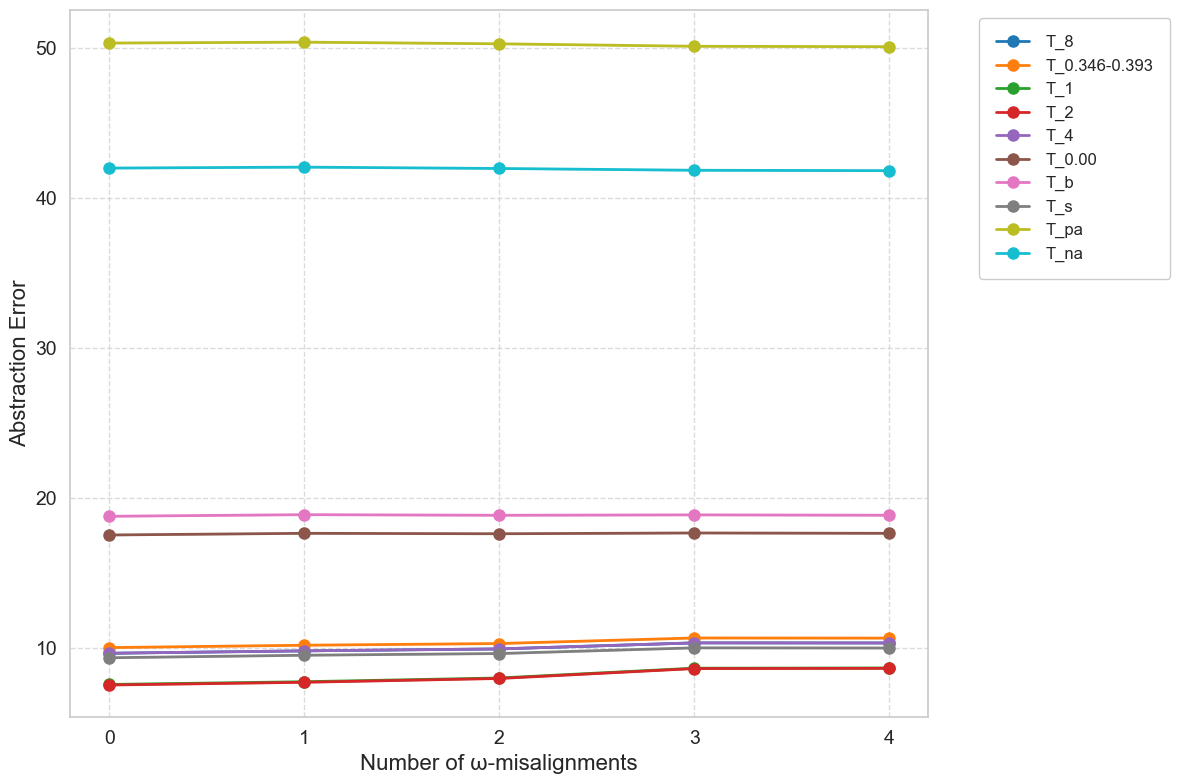

In [33]:
# Define misalignment levels to test
misalignment_levels = range(0, len(Ill))  # Test 0 to 15 misalignments
# Store results for plotting
omega_plot_results = {method: {'means': [], 'stds': []} for method in T_results_emp.keys()}

# Run experiment for each misalignment level
for num_mis in tqdm(misalignment_levels):
    abstraction_error = {name: [] for name in T_results_emp.keys()}
    
    for _ in range(1):  # Multiple runs for each misalignment level
        # Contaminate the omega map
        omega_cont = contaminate_omega_map(omega, num_mis)
        
        # # Generate new data pairs using the contaminated omega map
        # contaminated_data = evut.generate_empirical_data(
        #     LLmodels, 
        #     HLmodels, 
        #     omega_cont,  # Use contaminated omega map
        #     U_ll_hat, 
        #     U_hl_hat
        # )
        
        for name, res in T_results_emp.items():
            T = res['T_matrix']
            # total = 0
            
            # for iota in contaminated_data.keys():
            #     base, abst = contaminated_data[iota]
                
            #     # Normalize data
            #     base_norm = base #/ np.linalg.norm(base, 'fro')
            #     abst_norm = abst #/ np.linalg.norm(abst, 'fro')
                
            #     # Apply method and compute distance
            #     tau_base = base_norm @ T.T
            #     dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
            #     total += dist
            
            total = 0
            for iota in Ill:
                L_i = LLmodels[iota].F
                H_i = HLmodels[omega_cont[iota]].F
                
                if iota is not None:
                    D_l = L_i @ mod_noise(hat_dict['L'].T, iota)
                    D_h = H_i @ mod_noise(hat_dict['H'].T, omega_cont[iota])
                else:
                    D_l = L_i @ hat_dict['L'].T
                    D_h = H_i @ hat_dict['H'].T
                
                # Normalize
                base_norm = D_l #/ np.linalg.norm(D_l, 'fro')
                abst_norm = D_h #/ np.linalg.norm(D_h, 'fro')
                
                tau_base = T @ base_norm
                dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                total += dist
            # Store average error for this iteration
            iter_avg = total / len(Ill)
            abstraction_error[name].append(iter_avg)
    
    # Store results for this misalignment level
    for method in T_results_emp.keys():
        mean_e = np.mean(abstraction_error[method])
        std_e = np.std(abstraction_error[method])
        omega_plot_results[method]['means'].append(mean_e)
        omega_plot_results[method]['stds'].append(std_e)

# Plot results
methods_to_plot = list(T_results_emp.keys())
plot_omega_contamination_results(
    omega_plot_results, 
    misalignment_levels, 
    methods_to_plot=methods_to_plot
)

In [34]:
# Compute and print the overall averages across all misalignment levels
print("\n" + "="*100)
print("AVERAGE ERROR ACROSS ALL OMEGA MISALIGNMENTS (EMPIRICAL)")
print("="*100)
print(f"{'Method':<15} {'Mean ± CI (95%)':<35}")
print("-"*100)

# Compute averages for each method
method_averages = []
for method in T_results_emp.keys():
    # Get all means across misalignment levels
    all_means = omega_plot_results[method]['means']
    # Compute overall mean and std
    overall_mean = np.mean(all_means)
    overall_std = np.std(all_means)
    method_averages.append((method, overall_mean, overall_std))

# Sort methods by mean (worst to best)
method_averages.sort(key=lambda x: x[1], reverse=True)

# Print sorted averages
for method, mean, std in method_averages:
    ci = 1.96 * std
    print(f"{method:<15} {mean:>8.4f} ± {ci:<8.4f}")

print("="*100)


AVERAGE ERROR ACROSS ALL OMEGA MISALIGNMENTS (EMPIRICAL)
Method          Mean ± CI (95%)                    
----------------------------------------------------------------------------------------------------
T_pa             50.2115 ± 0.2335  
T_na             41.9120 ± 0.1744  
T_b              18.8295 ± 0.0720  
T_0.00           17.6032 ± 0.0919  
T_0.346-0.393    10.3508 ± 0.5027  
T_8               9.9985 ± 0.5481  
T_4               9.9985 ± 0.5481  
T_s               9.6854 ± 0.5161  
T_1               8.1130 ± 0.8927  
T_2               8.0814 ± 0.9041  
